In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools 
import random
import numpy as np
import matplotlib.lines as mlines
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
def load_file(f):
    with open(f, "rb") as rb:
        pickle.load(rb)
        #return pickle.load(rb)
        return CPU_Unpickler(rb).load()

In [2]:
def choice_lr(net,s,s0,L):
    if net=="cnn2":
        if s>2:
            if s0<4:
                lr = 0.01
            elif s0==4:
                lr = 0.003
            elif s0==6:
                lr = 0.0003
            if s==3 and n==4:
                if s0<4:
                    lr = 0.003
        else:
            if s0>0:
                if L>=3:
                    if s0<4:
                        lr = 0.01
                    elif s0==4:
                        lr = 0.003
                    else:
                        lr = 0.001
                elif L==2:
                    if s0<4:
                        lr = 0.1
                    elif s0==4:
                        lr = 0.03
                    else:
                        lr = 0.01
            else:
                lr = 0.01
            if L==1:
                if s0<4:
                    lr = 0.1
                else:
                    lr = .03
    return lr

def training_point(net,s,s0,L,n,m):
    if s>2: 
        p_pred = n**(L)
        #pmax = ((2*s0+2)**(2**L -1))*n**(2**L)


        if s0 <=4:
            xx= np.logspace(np.log10(int(p_pred)),np.log10(100*p_pred),15)
            xx =xx[:-1]
        else:
            xx= np.logspace(np.log10(p_pred),np.log10(500*p_pred),15)
            xx =xx[:-1]
            #xx1 = np.array([107999,135917])
            #xx = np.concatenate((xx,xx1))

        if s==3 or s==4:
            if L==2:
                xx1= np.logspace(np.log10(100*p_pred),np.log10(500*p_pred),15)
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(500*p_pred),np.log10(1000*p_pred),15)
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(1000*p_pred),np.log10(10000*p_pred),10)
                xx = np.concatenate((xx,xx1))
            if s==4:
                xx1= np.logspace(np.log10(1000*p_pred),np.log10(2000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(2000*p_pred),np.log10(10000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(10000*p_pred),np.log10(50000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
            
        if s==3 and n==4:
            p_pred = (s0+1)*m**(L)
            xx= np.logspace(np.log10(int(0.1*p_pred)),np.log10(10*p_pred),10)
            #xx = np.concatenate((xx,xx1))
            xx1= np.logspace(np.log10(int(10*p_pred)),np.log10(100*p_pred),10)
            xx = np.concatenate((xx,xx1))
        '''
        if s==3:
            p_pred = (s0+1)*m**(L)
            #p_max_used = min(pmax,110000)
            #p_pred = n**(L+1)
            if s0 <= 4 and s==3:
                #xx1= np.logspace(np.log10(int(1000*p_pred)),np.log10(2000*p_pred),10)
                #xx = np.concatenate((xx,xx1))
                xx= np.logspace(np.log10(int(0.1*p_pred)),np.log10(10*p_pred),15)
        '''    
    else:
        p_pred = n**(L+1)
        #pmax = ((2*s0+2)**(2**L -1))*n**(2**L)
        if L>1:
            if s0>0:
                if L>=3:
                    pmax = 110000

                    if s0 <4:
                        xx= np.logspace(np.log10(p_pred),np.log10(100*p_pred),15)

                    else:
                        xx= np.logspace(np.log10(p_pred),np.log10(300*p_pred),15)
                    if s0==1:
                        if n==8 or n==10:
                            xx0 = np.logspace(np.log10(int(0.1*p_pred)),np.log10(p_pred),5)
                            xx0 = xx0[:-1]
                            xx = np.concatenate((xx0,xx))
                elif L==2:
                    pmax = ((2*s0+2)**(2**L -1))*n**(2**L)
                    p_pred = n**(L+1)
                    p_max_used = min(pmax,110000)
                    #p_pred = n**(L+1)
                    if s0>=4:
                        xx= np.logspace(np.log10(p_pred),np.log10(p_max_used),15)
                    else:
                        xx= np.logspace(np.log10(p_pred),np.log10(pmax),15)

            else:
                p_pred_red = n**L
                xx= np.logspace(np.log10(int(0.2*p_pred_red)),np.log10(100*p_pred_red),15)
        else:
            p_pred_1 = n**L
            if s0 <4:
                xx= np.logspace(np.log10(p_pred_1),np.log10(200*p_pred_1),15)

            else:
                xx= np.logspace(np.log10(p_pred_1),np.log10(500*p_pred_1),15)

        xx =xx[:-1]
    
    return xx

def load_net(net,ptr,n,m,L,s0,s,seed,width,lr):
    if s>2:
        if ptr>= 176055 and s==4:
            lr_tmp = 0.005
            tmp = load_file("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr_tmp)+".npy")
        else:
            tmp = load_file("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
    else:
        if L==1:
        #print(ptr)
            tmp = load_file("cnn_L1/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")

        else:
            if s0==0:
                tmp = load_file("check_s0/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")

            else:
                if L<=3:
                    tmp = load_file(net+"_data_L"+str(L)+"_A_0s/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
                if L>3:
                    tmp = load_file(net+"_data_L"+str(3)+"_A_0s/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
    return tmp


def training_point_new(xx,net,n,m,L,s0,s,width,lr):
    xx_new = []
                
    for ptrx in xx:

        #print(ptrx,pmax)
        ptr = int(ptrx) 


        tmp_seed = 0

        num_seeds = 0
        for (idx_seed,seed) in enumerate(np.array([1])):

            try:

                tmp = load_net(net,ptr,n,m,L,s0,s,seed,width,lr)
                tmp_seed += (100-tmp[choice]["acc"])/100
                num_seeds +=1
                xx_new.append(ptr)
            except:
                #if s>2:
                #    print("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
                #print('s0 not happened: '+str(s0)+'and P: '+str(ptr))
                pass
    xx_new = torch.tensor(xx_new)
    return xx_new

In [59]:
##TASK TASK TASK

ns = np.array([6])#[3,4,6,8,10,12])
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

###### L=3 ########
#NO WHITENING
choice = "best"

lr = .1
width = 512
seed = 0
nets =["cnn2"]#

def find_closest_position(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

sss = [2,3]#[2,3,4]
s0s = [0,1,2,4]#[0,1,2,4]
Ls= [2,3] #[2,3]
bs = 20
pchecks = []
for i in range(1,5):
    pchecks += [10**i]
    pchecks += [2*10**i]
    pchecks += [3*10**i]
    pchecks += [5*10**i]
    pchecks += [7*10**i]
    pchecks += [8*10**i]
    pchecks += [9*10**i]

for pcheck in pchecks:
    for (idx_L,L) in enumerate(Ls):
        #print('L: '+str(L))
        for (idx_s,s) in enumerate(sss):
            #print('s: '+str(s))
    
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
    
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    
                    col = colors[idxn]
                    for (idxnet,net) in enumerate(nets):
                        #print(n)
                        lr = choice_lr(net,s,s0,L)
    
                        try:
                             
                            if (L==3 and s==2) or (s==3 and n==4) or (s==4 and L==2) or (L==2 and s==3 and n==6):
                                mat_terr = torch.load('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                                mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                                mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                                xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            else:
                                
                                #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                                mat_terr = torch.load('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                                mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                                mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                                
                                if (n==6 and s==2 and L==2):
                                    xx= training_point(net,s,s0,L,n,m)
                                else:    
                                    xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                               
                            if len(xx):
                                target_value = pcheck
                                if s0>0 and L==2 and s==2:
                                    target_value  = target_value 
                                else:
                                    target_value  = int(target_value/n)
                                closest_index = find_closest_position(xx, target_value)
                                ##print(xx[closest_index])
                                #print(target_value)
                                #print(pcheck)
                                if abs(target_value - xx[closest_index])<= target_value :
                                    
                                    #print(mat_all_sem[:,1,0])
                                    torch.save(mat_terr[closest_index],'phaseDiagram_terr/terr_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')          
                                    torch.save(mat_all_sem[closest_index,L,0],'phaseDiagram_S/S_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')
                                    torch.save(mat_all_pos[closest_index,L,0],'phaseDiagram_D/D_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')
                        except:
                            #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            #print(n)
                            pass
                    

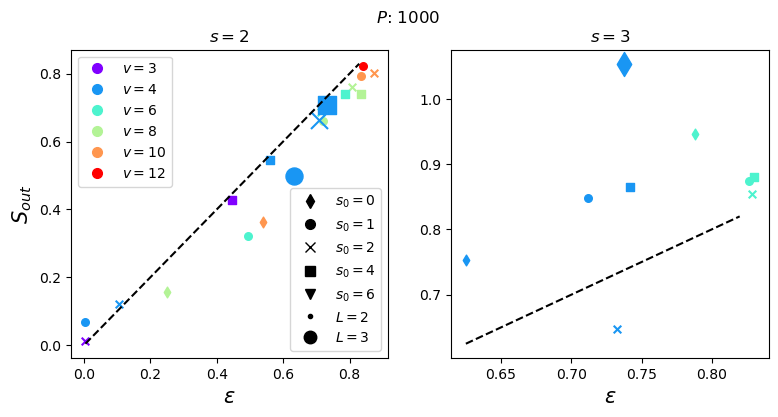

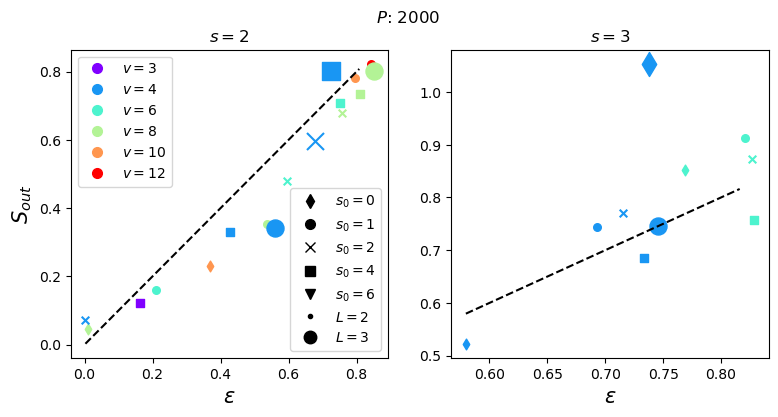

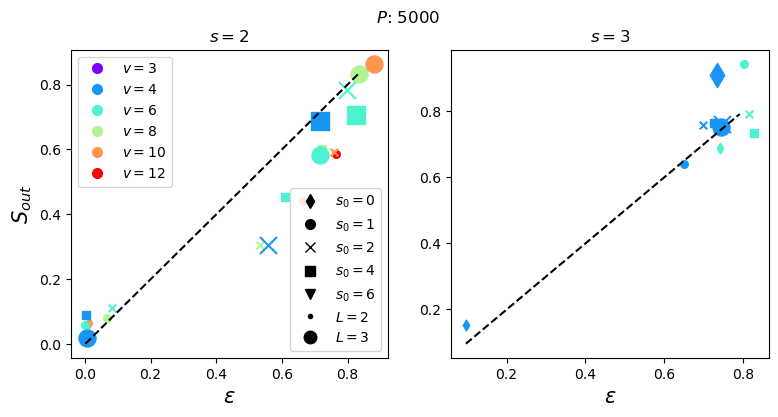

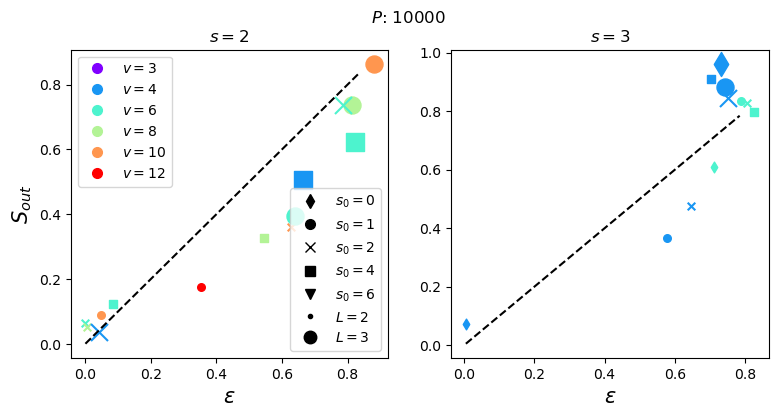

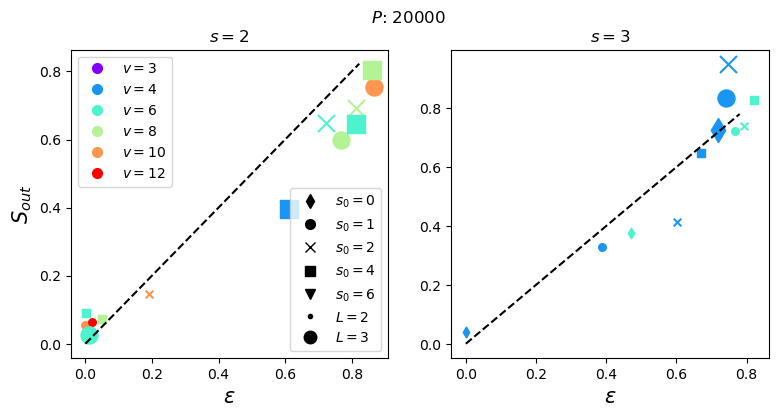

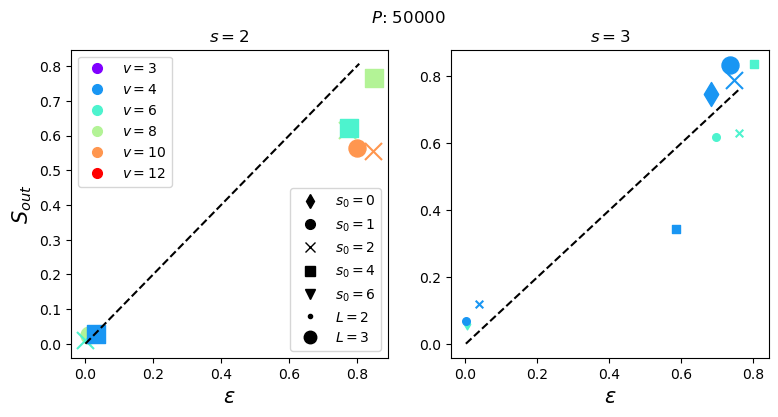

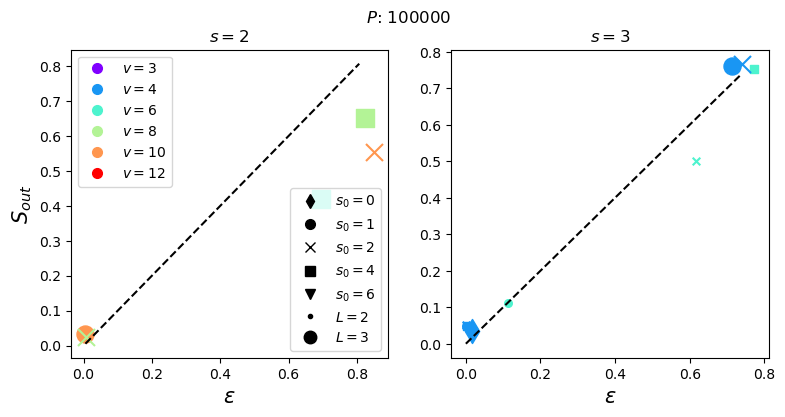

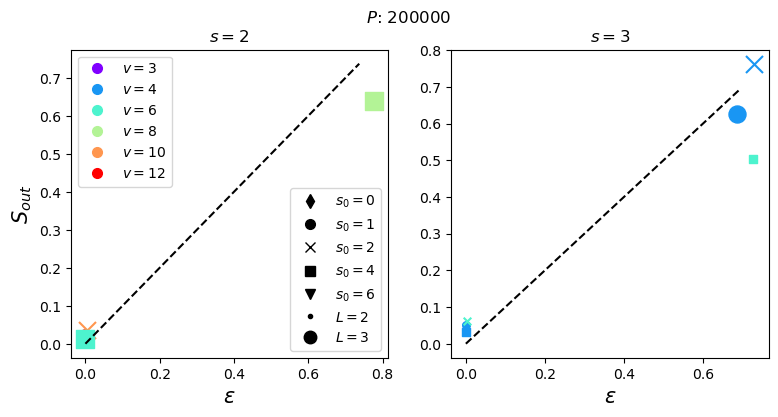

In [89]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [0,1,2,4,6]
    
Ls= [2,3]
sss = [2,3]

pchecks = [1000,2000,5000,10000,20000,50000,10**5,2*10**5]#,5*10**5,10**6]


net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

flag_s = np.zeros(len(ns))
flag_s0 = np.zeros(len(ns))
flag_L = np.zeros(len(ns))


for pcheck in pchecks:
    
    fig, axs = plt.subplots(1,2, figsize = (9,4))
    fig.suptitle(r'$P$: '+str(pcheck))
    
    for (idx_s,s) in enumerate(sss):
        if s==2:
            idxx = 0
        elif s==3:
            idxx = 1
        #print('s: '+str(s))
        
        vs = []
        for (idx_L,L) in enumerate(Ls):
            #print('L: '+str(L))
            expo = 2
            if L==2:
                alpha = 1
                size = 30
            elif L==3:
                alpha = 1
                size =150
            
            
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
                if s0==0:
                    mar = "d"
                elif s0==1:
                    mar = "o"
                elif s0==2:
                    mar = "x"
                elif s0==4:
                    mar = "s"
                elif s0==6:
                    mar = "v"
                
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    
                    try:
                        
                        terr = torch.load('phaseDiagram_terr/terr_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        terr = np.array(terr)
                        if terr==0.0:
                            terr = terr #1e-9
                        sens_s = torch.load('phaseDiagram_S/S_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        sens_s = np.array(sens_s)
                        
                        col = colors[idxn]
                        fact = 1#(s)**(L*.5)
                        expo =2                        
                        if terr>0:
                            axs[idxx].scatter([terr],[sens_s],marker = mar,color = col,s=size, alpha = alpha)
                            #label = r'v: %d'%(n),
                            if s==4:
                                axs[idxx].scatter([terr],[sens_],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)
                            
                            vs+=[terr]
                        
                    except:
                        pass
                        
        min0 = min(vs)
        max0 = max(vs)
       # print(min0,max0)
        ps = np.arange(min0,max0,(max0-min0)/20)
        #C = max(pstars.flatten().tolist())/max0
        if idxx==0:
            axs[0].plot(ps,ps,label=r'$y=x$',color='black',ls='--')
        elif idxx ==1:
            axs[idxx].plot(ps,ps,label=r'$y=x$',color='black',ls='--')
        axs[idxx].set_title(r"$s= %d$" %(s))
        #axs[1].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')
    '''
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    '''
    axs[0].set_xlabel(r'$\varepsilon$',size = 15)
    axs[1].set_xlabel(r'$\varepsilon$',size = 15)
    axs[0].set_ylabel(r'$S_{out}$',size = 15)
    #L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
    #              markersize=7, label=r'$L=3$')
    
    s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
                  markersize=7, label=r'$s_0=0$')
    s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=7, label=r'$s_0=1$')
    s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                  markersize=7, label=r'$s_0=2$')
    s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                  markersize=7, label=r'$s_0=4$')
    s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
                  markersize=7, label=r'$s_0=6$')
    
    s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
                  markersize=3, label=r'$L=2$')
    s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=9, label=r'$L=3$')
    

    
    legend1 = axs[0].legend(handles=[s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
    
    n0 = []
    for i in range(len(ns)):
        n0 += [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                      markersize=7, label=r'$v=%d$'%ns[i])]
    axs[0].legend(handles=n0,loc = 'upper left') 
    
    axs[0].add_artist(legend1)
    
    plt.savefig("figures/phaseDiagram_terr_S_cnn2_P_%d.png"%(pcheck) , bbox_inches='tight')
    plt.savefig("figures/phaseDiagram_terr_S_cnn2P_%d.pdf"%(pcheck) , bbox_inches='tight')

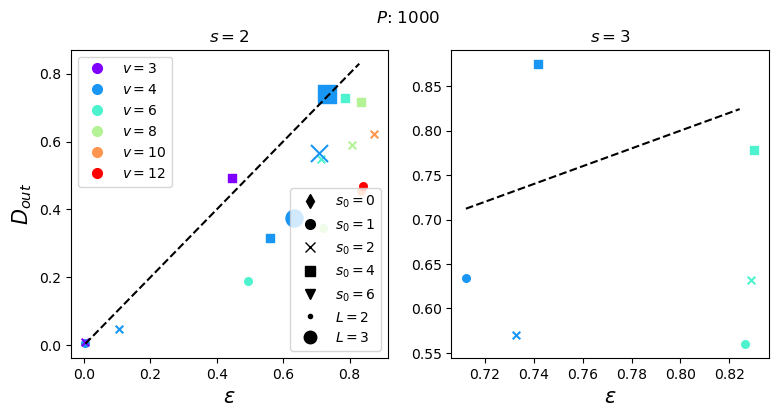

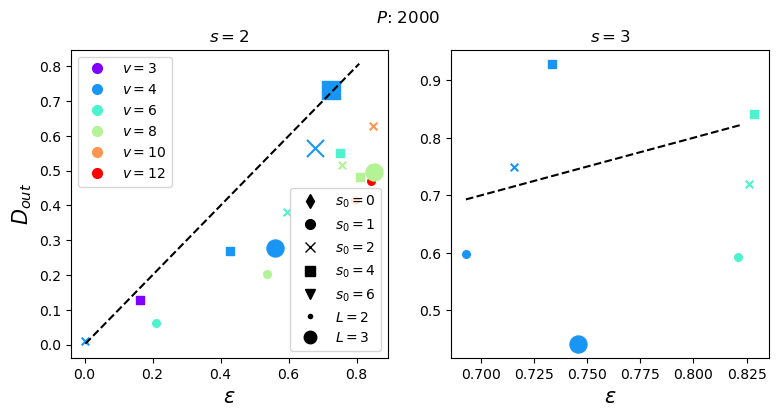

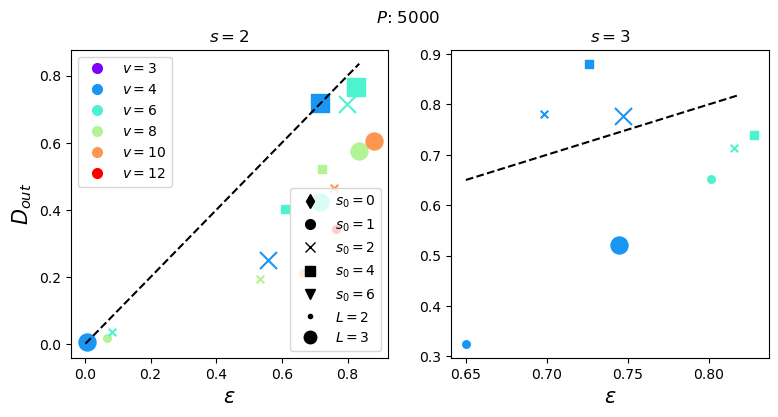

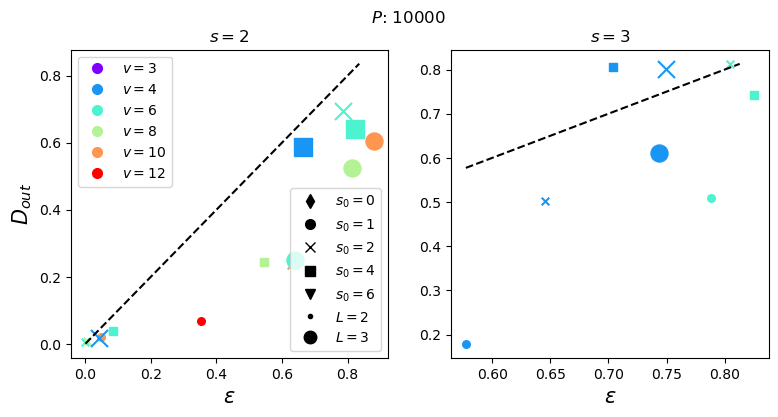

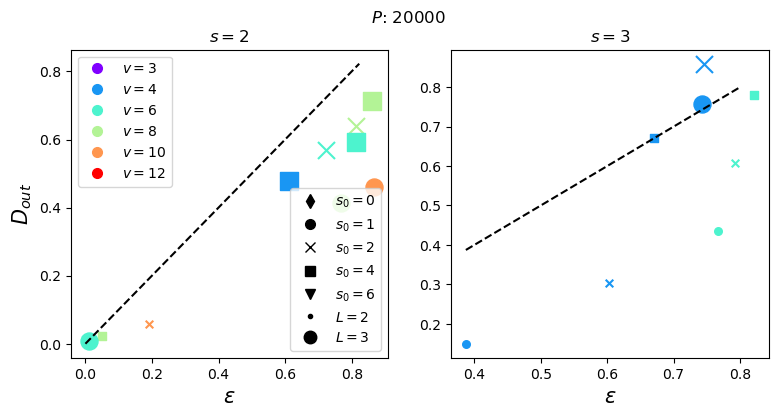

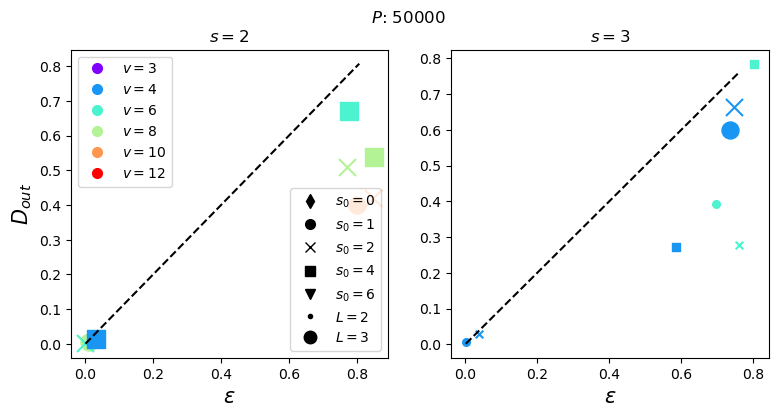

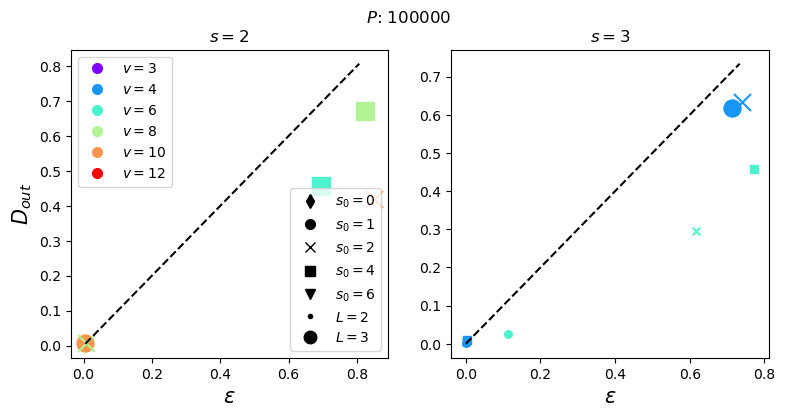

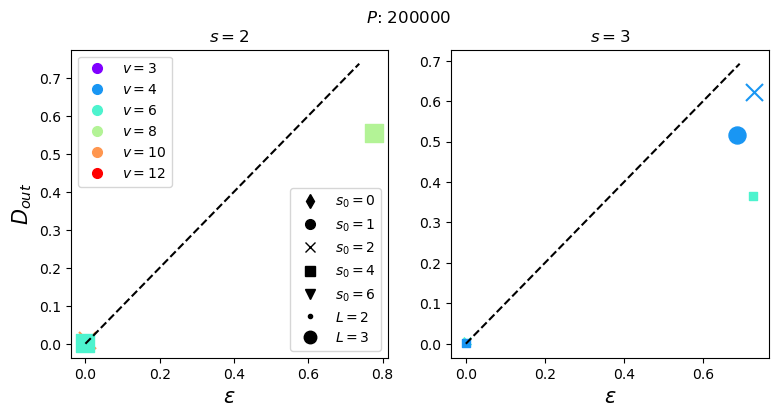

In [90]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [1,2,4,6]
    
Ls= [2,3]
sss = [2,3]

pchecks = [1000,2000,5000,10000,20000,50000,10**5,2*10**5]#,5*10**5,10**6]


net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))


for pcheck in pchecks:
    
    fig, axs = plt.subplots(1,2, figsize = (9,4))
    fig.suptitle(r'$P$: '+str(pcheck))
    
    for (idx_s,s) in enumerate(sss):
        if s==2:
            idxx = 0
        elif s==3:
            idxx = 1
        #print('s: '+str(s))
    
        vs = []
        for (idx_L,L) in enumerate(Ls):
            #print('L: '+str(L))
            expo = 2
            if L==2:
                alpha = 1
                size = 30
            elif L==3:
                alpha = 1
                size =150
            
    
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
                if s0==0:
                    mar = "d"
                elif s0==1:
                    mar = "o"
                elif s0==2:
                    mar = "x"
                elif s0==4:
                    mar = "s"
                elif s0==6:
                    mar = "v"
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    try:
                        
                        terr = torch.load('phaseDiagram_terr/terr_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        terr = np.array(terr)
                        if terr==0.0:
                            terr = terr #1e-9
                        sens_s = torch.load('phaseDiagram_D/D_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        sens_s = np.array(sens_s)
                        
                        col = colors[idxn]
                        fact = 1#(s)**(L*.5)
                        expo =2                        
                        if terr>0:
                            if idx_s0==1 and idx_L==0 and idx_s ==0:
                                #print(sens_s)
                                axs[idxx].scatter([terr],[sens_s],label = r'v: %d'%(n),marker = mar,color = col,s=size, alpha = alpha)
                                
                            else:
                                axs[idxx].scatter([terr],[sens_s],marker = mar,color = col, alpha = alpha,s = size)
        
                            if s==4:
                                axs[idxx].scatter([terr],[sens_],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)
                            
                            vs+=[terr]
                        
                    except:
                        pass
                        
        min0 = min(vs)
        max0 = max(vs)
       # print(min0,max0)
        ps = np.arange(min0,max0,(max0-min0)/20)
        #C = max(pstars.flatten().tolist())/max0
        offset = 0#-0.1
        if idxx==0:
            axs[0].plot(ps,ps+offset,label=r'$y=x$',color='black',ls='--')
        elif idxx ==1:
            axs[idxx].plot(ps,ps+offset,label=r'$y=x$',color='black',ls='--')
        axs[idxx].set_title(r"$s= %d$" %(s))
        #axs[1].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')
    '''
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    '''
    axs[0].set_xlabel(r'$\varepsilon$',size = 15)
    axs[1].set_xlabel(r'$\varepsilon$',size = 15)
    axs[0].set_ylabel(r'$D_{out}$',size = 15)
    #L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
    #              markersize=7, label=r'$L=3$')
    
    s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
                  markersize=7, label=r'$s_0=0$')
    s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=7, label=r'$s_0=1$')
    s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                  markersize=7, label=r'$s_0=2$')
    s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                  markersize=7, label=r'$s_0=4$')
    s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
                  markersize=7, label=r'$s_0=6$')
    
    s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
                  markersize=3, label=r'$L=2$')
    s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=9, label=r'$L=3$')
    

    
    legend1 = axs[0].legend(handles=[s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
    
    n0 = []
    for i in range(len(ns)):
        n0 += [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                      markersize=7, label=r'$v=%d$'%ns[i])]
    axs[0].legend(handles=n0,loc = 'upper left') 
    
    axs[0].add_artist(legend1)
    plt.savefig("figures/phaseDiagram_terr_D_cnn2_P_%d.png"%(pcheck) , bbox_inches='tight')
    plt.savefig("figures/phaseDiagram_terr_D_cnn2P_%d.pdf"%(pcheck) , bbox_inches='tight')

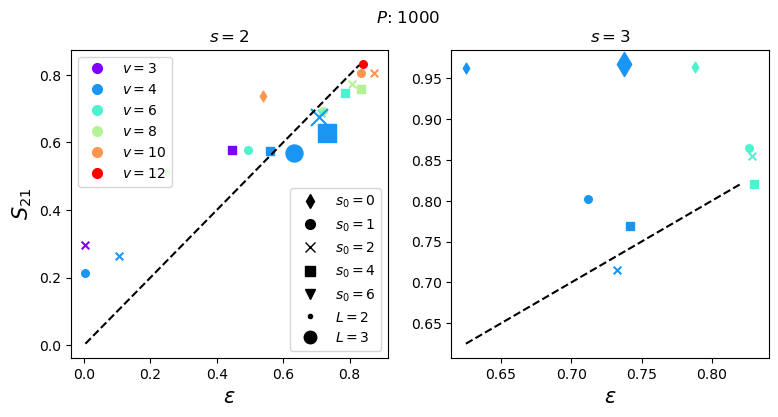

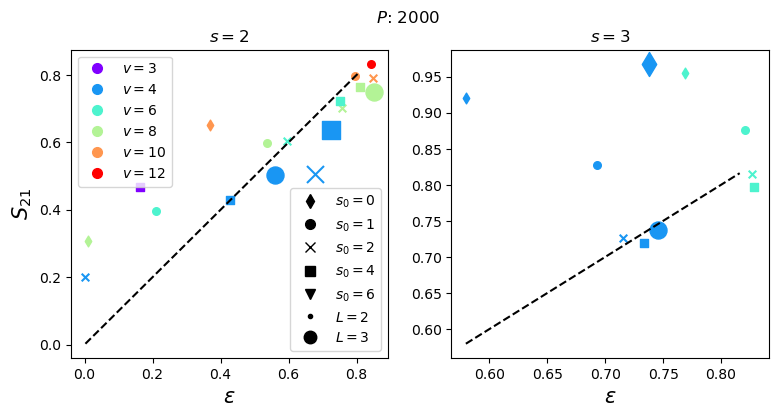

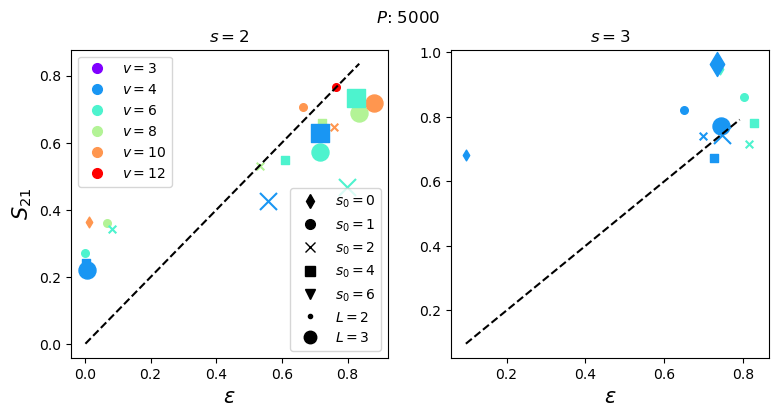

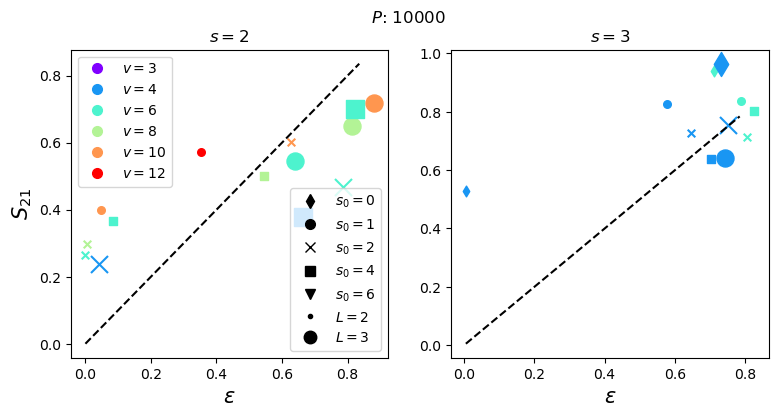

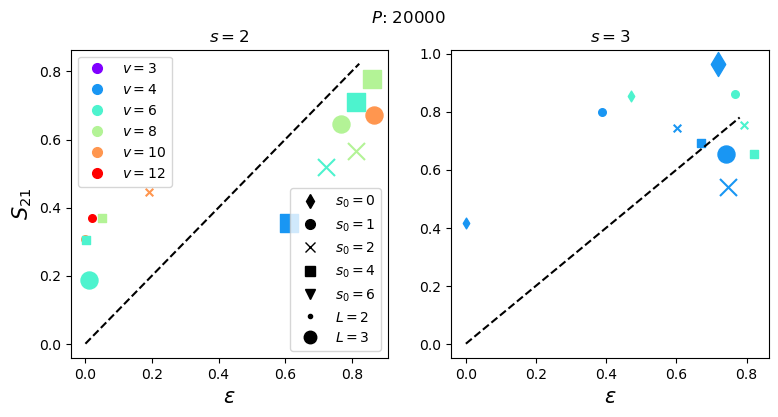

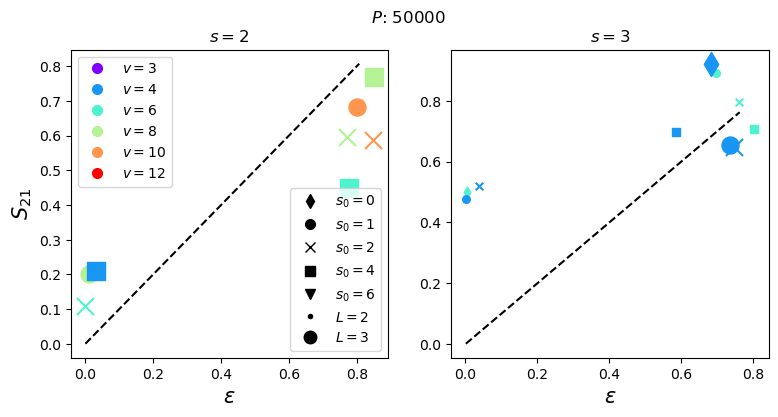

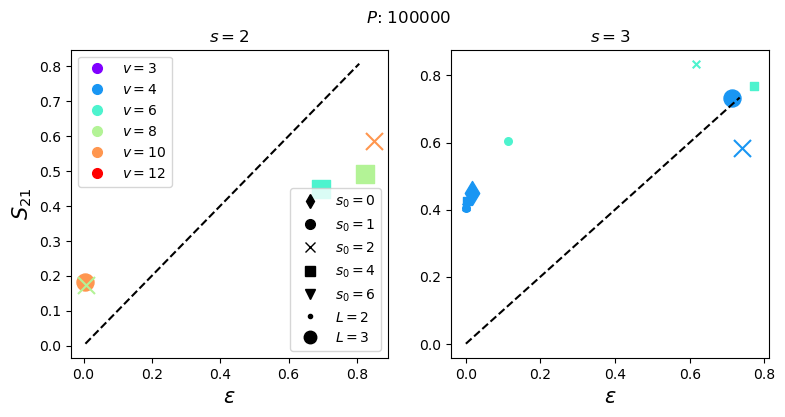

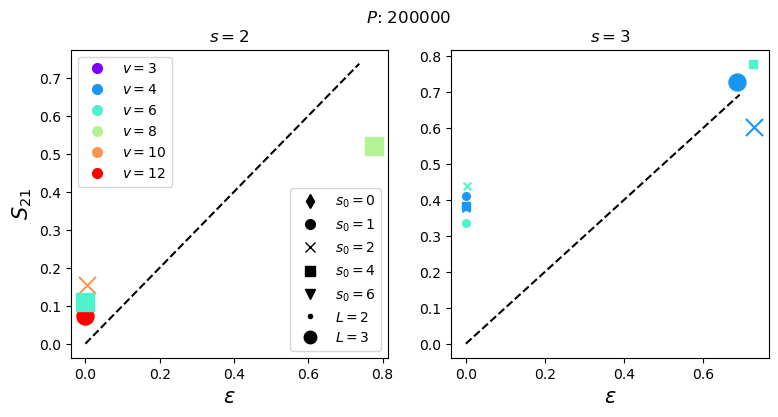

In [92]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [0,1,2,4,6]
    
Ls= [2,3]
sss = [2,3]

pchecks = [1000,2000,5000,10000,20000,50000,10**5,2*10**5]#,5*10**5,10**6]


net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

flag_s = np.zeros(len(ns))
flag_s0 = np.zeros(len(ns))
flag_L = np.zeros(len(ns))


for pcheck in pchecks:
    
    fig, axs = plt.subplots(1,2, figsize = (9,4))
    fig.suptitle(r'$P$: '+str(pcheck))
    
    for (idx_s,s) in enumerate(sss):
        if s==2:
            idxx = 0
        elif s==3:
            idxx = 1
        #print('s: '+str(s))
        
        vs = []
        for (idx_L,L) in enumerate(Ls):
            #print('L: '+str(L))
            expo = 2
            if L==2:
                alpha = 1
                size = 30
            elif L==3:
                alpha = 1
                size =150
            
            
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
                if s0==0:
                    mar = "d"
                elif s0==1:
                    mar = "o"
                elif s0==2:
                    mar = "x"
                elif s0==4:
                    mar = "s"
                elif s0==6:
                    mar = "v"
                
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    
                    try:
                        
                        terr = torch.load('phaseDiagram_terr/terr_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        terr = np.array(terr)
                        if terr==0.0:
                            terr = terr #1e-9
                        sens_s = torch.load('phaseDiagram_S/S21_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        sens_s = np.array(sens_s)
                        
                        col = colors[idxn]
                        fact = 1#(s)**(L*.5)
                        expo =2                        
                        if terr>0:
                            axs[idxx].scatter([terr],[sens_s],marker = mar,color = col,s=size, alpha = alpha)
                            #label = r'v: %d'%(n),
                            if s==4:
                                axs[idxx].scatter([terr],[sens_],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)
                            
                            vs+=[terr]
                        
                    except:
                        pass
                        
        min0 = min(vs)
        max0 = max(vs)
       # print(min0,max0)
        ps = np.arange(min0,max0,(max0-min0)/20)
        #C = max(pstars.flatten().tolist())/max0
        if idxx==0:
            axs[0].plot(ps,ps,label=r'$y=x$',color='black',ls='--')
        elif idxx ==1:
            axs[idxx].plot(ps,ps,label=r'$y=x$',color='black',ls='--')
        axs[idxx].set_title(r"$s= %d$" %(s))
        #axs[1].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')
    '''
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    '''
    axs[0].set_xlabel(r'$\varepsilon$',size = 15)
    axs[1].set_xlabel(r'$\varepsilon$',size = 15)
    axs[0].set_ylabel(r'$S_{21}$',size = 15)
    #L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
    #              markersize=7, label=r'$L=3$')
    
    s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
                  markersize=7, label=r'$s_0=0$')
    s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=7, label=r'$s_0=1$')
    s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                  markersize=7, label=r'$s_0=2$')
    s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                  markersize=7, label=r'$s_0=4$')
    s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
                  markersize=7, label=r'$s_0=6$')
    
    s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
                  markersize=3, label=r'$L=2$')
    s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=9, label=r'$L=3$')
    

    
    legend1 = axs[0].legend(handles=[s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
    
    n0 = []
    for i in range(len(ns)):
        n0 += [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                      markersize=7, label=r'$v=%d$'%ns[i])]
    axs[0].legend(handles=n0,loc = 'upper left') 
    
    axs[0].add_artist(legend1)
    
    plt.savefig("figures/phaseDiagram_terr_S21_cnn2_P_%d.png"%(pcheck) , bbox_inches='tight')
    plt.savefig("figures/phaseDiagram_terr_S21_cnn2P_%d.pdf"%(pcheck) , bbox_inches='tight')

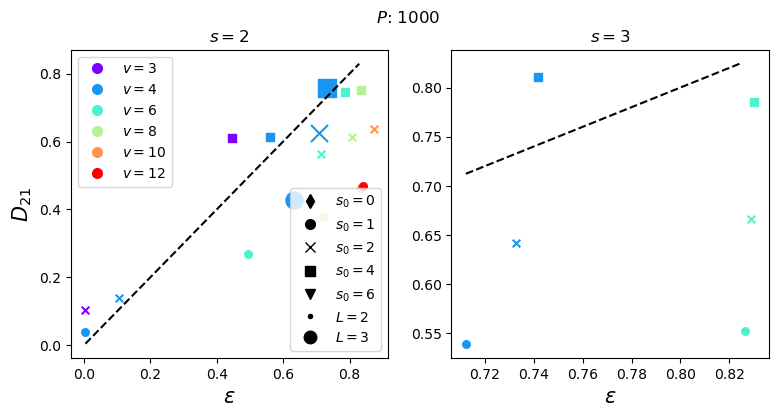

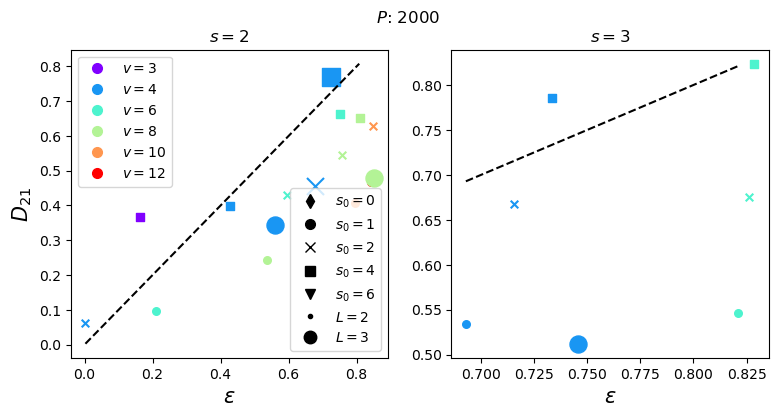

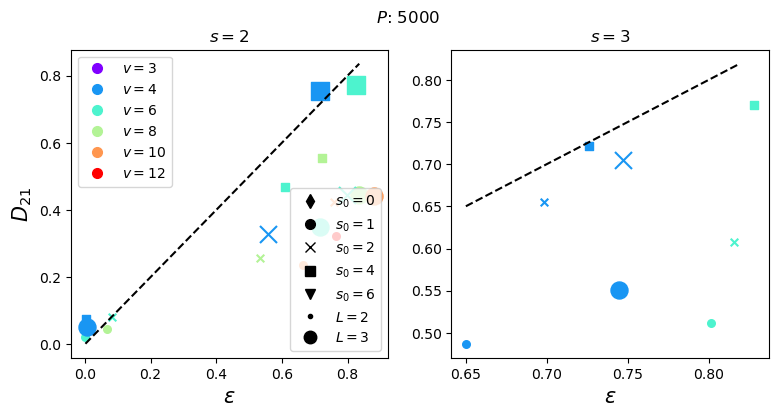

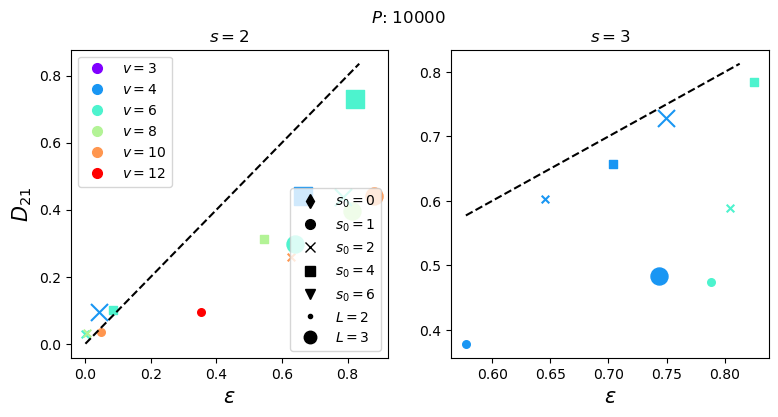

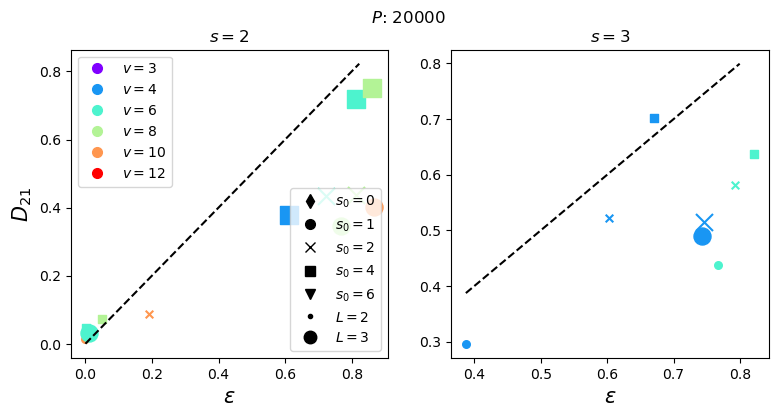

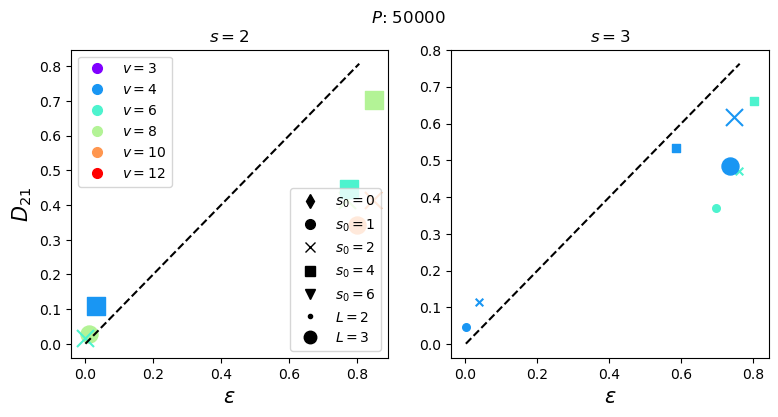

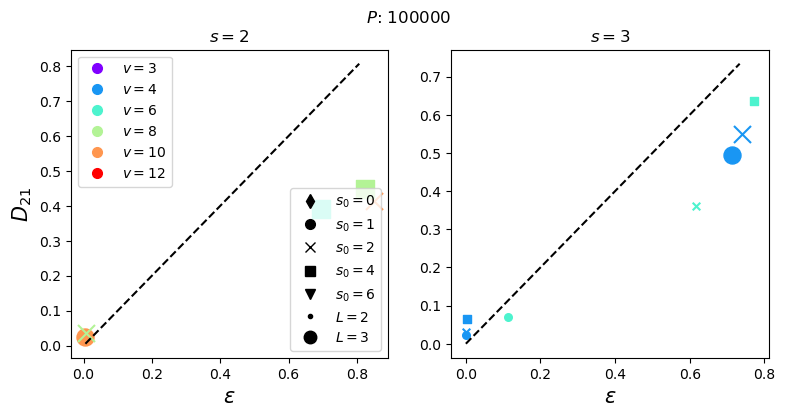

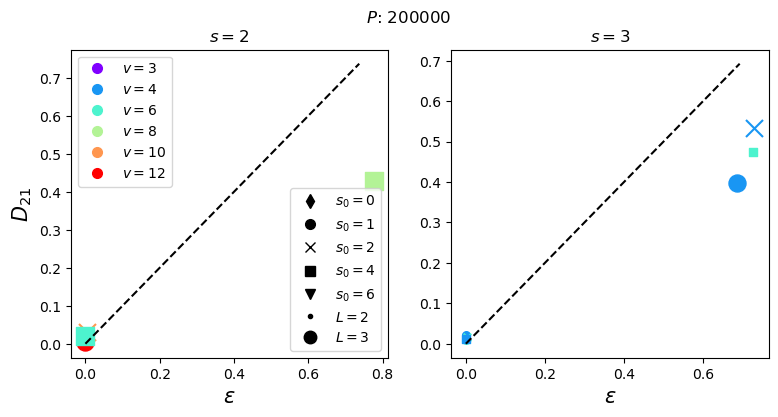

In [93]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [1,2,4,6]
    
Ls= [2,3]
sss = [2,3]

pchecks = [1000,2000,5000,10000,20000,50000,10**5,2*10**5]#,5*10**5,10**6]


net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))


for pcheck in pchecks:
    
    fig, axs = plt.subplots(1,2, figsize = (9,4))
    fig.suptitle(r'$P$: '+str(pcheck))
    
    for (idx_s,s) in enumerate(sss):
        if s==2:
            idxx = 0
        elif s==3:
            idxx = 1
        #print('s: '+str(s))
    
        vs = []
        for (idx_L,L) in enumerate(Ls):
            #print('L: '+str(L))
            expo = 2
            if L==2:
                alpha = 1
                size = 30
            elif L==3:
                alpha = 1
                size =150
            
    
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
                if s0==0:
                    mar = "d"
                elif s0==1:
                    mar = "o"
                elif s0==2:
                    mar = "x"
                elif s0==4:
                    mar = "s"
                elif s0==6:
                    mar = "v"
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    try:
                        
                        terr = torch.load('phaseDiagram_terr/terr_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        terr = np.array(terr)
                        if terr==0.0:
                            terr = terr #1e-9
                        sens_s = torch.load('phaseDiagram_D/D21_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        sens_s = np.array(sens_s)
                        
                        col = colors[idxn]
                        fact = 1#(s)**(L*.5)
                        expo =2                        
                        if terr>0:
                            if idx_s0==1 and idx_L==0 and idx_s ==0:
                                #print(sens_s)
                                axs[idxx].scatter([terr],[sens_s],label = r'v: %d'%(n),marker = mar,color = col,s=size, alpha = alpha)
                                
                            else:
                                axs[idxx].scatter([terr],[sens_s],marker = mar,color = col, alpha = alpha,s = size)
        
                            if s==4:
                                axs[idxx].scatter([terr],[sens_],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)
                            
                            vs+=[terr]
                        
                    except:
                        pass
                        
        min0 = min(vs)
        max0 = max(vs)
       # print(min0,max0)
        ps = np.arange(min0,max0,(max0-min0)/20)
        #C = max(pstars.flatten().tolist())/max0
        offset = 0#-0.1
        if idxx==0:
            axs[0].plot(ps,ps+offset,label=r'$y=x$',color='black',ls='--')
        elif idxx ==1:
            axs[idxx].plot(ps,ps+offset,label=r'$y=x$',color='black',ls='--')
        axs[idxx].set_title(r"$s= %d$" %(s))
        #axs[1].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')
    '''
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    '''
    axs[0].set_xlabel(r'$\varepsilon$',size = 15)
    axs[1].set_xlabel(r'$\varepsilon$',size = 15)
    axs[0].set_ylabel(r'$D_{21}$',size = 15)
    #L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
    #              markersize=7, label=r'$L=3$')
    
    s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
                  markersize=7, label=r'$s_0=0$')
    s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=7, label=r'$s_0=1$')
    s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                  markersize=7, label=r'$s_0=2$')
    s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                  markersize=7, label=r'$s_0=4$')
    s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
                  markersize=7, label=r'$s_0=6$')
    
    s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
                  markersize=3, label=r'$L=2$')
    s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=9, label=r'$L=3$')
    

    
    legend1 = axs[0].legend(handles=[s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
    
    n0 = []
    for i in range(len(ns)):
        n0 += [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                      markersize=7, label=r'$v=%d$'%ns[i])]
    axs[0].legend(handles=n0,loc = 'upper left') 
    
    axs[0].add_artist(legend1)
    plt.savefig("figures/phaseDiagram_terr_D21_cnn2_P_%d.png"%(pcheck) , bbox_inches='tight')
    plt.savefig("figures/phaseDiagram_terr_D21_cnn2P_%d.pdf"%(pcheck) , bbox_inches='tight')

[100, 200, 300, 500, 700, 800, 900, 1000, 2000, 3000, 5000, 7000, 8000, 9000, 10000, 20000, 30000, 50000, 70000, 80000, 90000]


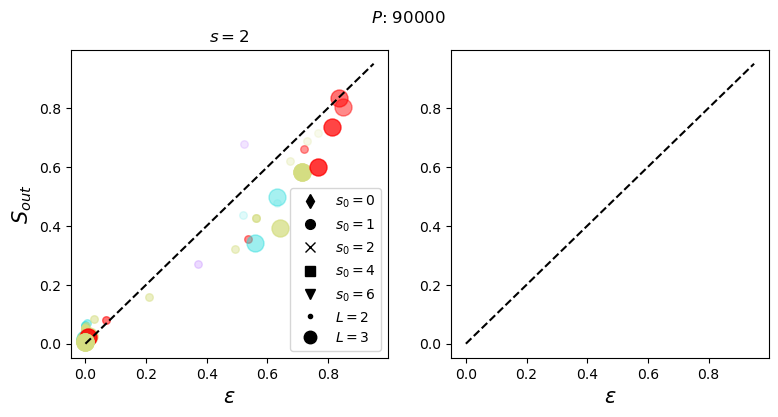

In [68]:
ns = ns = np.array([3,4,6,8])   #[3,4,6,8,10,12])
s0s = [1] #[0,1,2,4,6]
    
Ls= [2,3] #[2,3]
sss = [2] #[2,3]


net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

flag_s = np.zeros(len(ns))
flag_s0 = np.zeros(len(ns))
flag_L = np.zeros(len(ns))

fig, axs = plt.subplots(1,2, figsize = (9,4))
fig.suptitle(r'$P$: '+str(pcheck))

pchecks = []
for i in range(2,5):
    pchecks += [10**i]
    pchecks += [2*10**i]
    pchecks += [3*10**i]
    pchecks += [5*10**i]
    pchecks += [7*10**i]
    pchecks += [8*10**i]
    pchecks += [9*10**i]
print(pchecks)
alphas = [i for i in np.linspace(0.1,1,len(pchecks))]
#print(alphas)

for (idx_L,L) in enumerate(Ls):

    
    
    
    for (idxp,pcheck) in enumerate(pchecks):
    
    
    
        for (idx_s,s) in enumerate(sss):
            
            if s==2:
                idxx = 0
            elif s==3:
                idxx = 1
            axs[idxx].set_title(r"$s= %d$" %(s))
            
            vs = []
            
                
            #print('L: '+str(L))
            expo = 2
            if L==2:
                alpha = 1
                size = 30
            elif L==3:
                alpha = 1
                size =150
            
            
            for (idx_s0,s0) in enumerate(s0s):
                #print('s0: '+str(s0))
    
                if s0==0:
                    mar = "d"
                elif s0==1:
                    mar = "o"
                elif s0==2:
                    mar = "x"
                elif s0==4:
                    mar = "s"
                elif s0==6:
                    mar = "v"
                
                for (idxn,n) in enumerate(ns):
                    m = n**(s-1)
                    
                    try:
                        
                        terr = torch.load('phaseDiagram_terr/terr_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        terr = np.array(terr)
                        
                        if terr==0.0:
                            terr = terr #1e-9
                        sens_s = torch.load('phaseDiagram_S/S_P_'+str(pcheck)+"_"+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                        sens_s = np.array(sens_s)
                        
                        col = colors[idxn]
                        fact = 1#(s)**(L*.5)
                        expo =2                        
                        #if terr>0:
                        axs[idxx].scatter([terr],[sens_s],marker = mar,color = col,s=size, alpha = alphas[idxp], label = r'$P=%d$'%pcheck)
                        #label = r'v: %d'%(n),
                        if s==4:
                            axs[idxx].scatter([terr],[sens_],marker = r'$s=4$',color = 'black', alpha = alphas[idxp],s = 1000)
                        
                        vs+=[terr]
                        
                    except:
                        pass
                        
min0 = 0#min(vs)
max0 = 1# max(vs)
# print(min0,max0)
ps = np.arange(min0,max0,(max0-min0)/20)
#C = max(pstars.flatten().tolist())/max0
axs[0].plot(ps,ps,label=r'$y=x$',color='black',ls='--')
axs[1].plot(ps,ps,label=r'$y=x$',color='black',ls='--')

#axs[1].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')
'''
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
'''
axs[0].set_xlabel(r'$\varepsilon$',size = 15)
axs[1].set_xlabel(r'$\varepsilon$',size = 15)
axs[0].set_ylabel(r'$S_{out}$',size = 15)
#L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
#              markersize=7, label=r'$L=3$')

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')

s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
              markersize=3, label=r'$L=2$')
s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=9, label=r'$L=3$')



legend1 = axs[0].legend(handles=[s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 

n0 = []
for i in range(len(ns)):
    n0 += [mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                  markersize=7, label=r'$v=%d$'%ns[i])]
#axs[0].legend()#handles=n0,loc = 'upper left') 

#axs[0].add_artist(legend1)
    
    #plt.savefig("figures/phaseDiagram_terr_S_cnn2_P_%d.png"%(pcheck) , bbox_inches='tight')
    #plt.savefig("figures/phaseDiagram_terr_S_cnn2P_%d.pdf"%(pcheck) , bbox_inches='tight')